In [1]:
import os
import glob
import time
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage.filters import gaussian_filter as gf
from hyss_util import *

In [2]:
# -- matplotlib defaults
plt.rcParams["figure.figsize"] = (7, 4)
plt.rcParams["image.interpolation"] = "nearest"
plt.rcParams["image.cmap"] = "gist_gray"

In [3]:
%matplotlib widget

In [4]:
# -- get the file list
fname0 = os.path.join(os.environ["LTCO_HSI0"], "full frame 20ms faster_VNIR.raw")
fname1 = os.path.join(os.environ["LTCO_HSI1"], "night_00000.raw")

In [5]:
# -- read in the raw data
hsi0 = read_hyper(fname0)

reading and parsing full frame 20ms faster_VNIR.hdr...
reading full frame 20ms faster_VNIR.raw...


In [6]:
# -- get the luminosity image
t0 = time.time()
imgL = hsi0.data.mean(axis=0)
print("luminosity image created in {0:.2f}s".format(time.time() - t0))

luminosity image created in 1.69s


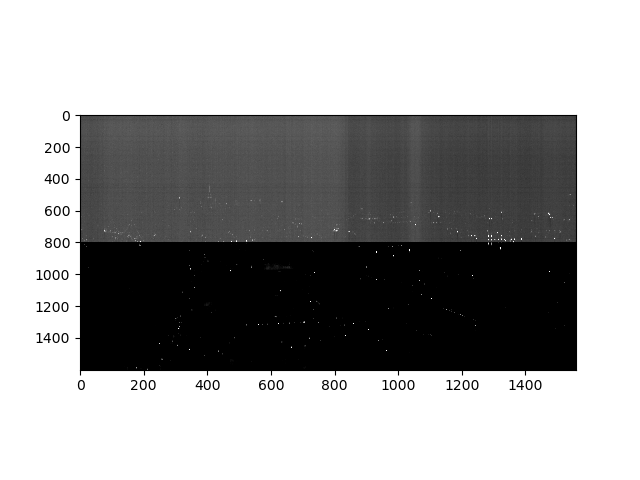

In [28]:
# -- visualize the luminosity image
plt.close("all")
plt.imshow(imgL, aspect=0.5, clim=[50, 75])

In [8]:
arr = imgL - np.median(imgL, axis=1, keepdims=True)
arr = arr - np.median(arr, axis=0, keepdims=True)

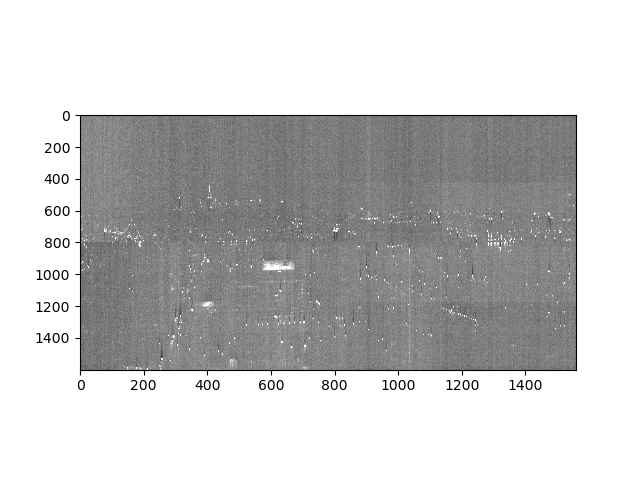

In [29]:
plt.close("all")
plt.imshow(arr, aspect=0.5, clim=[-3, 3])

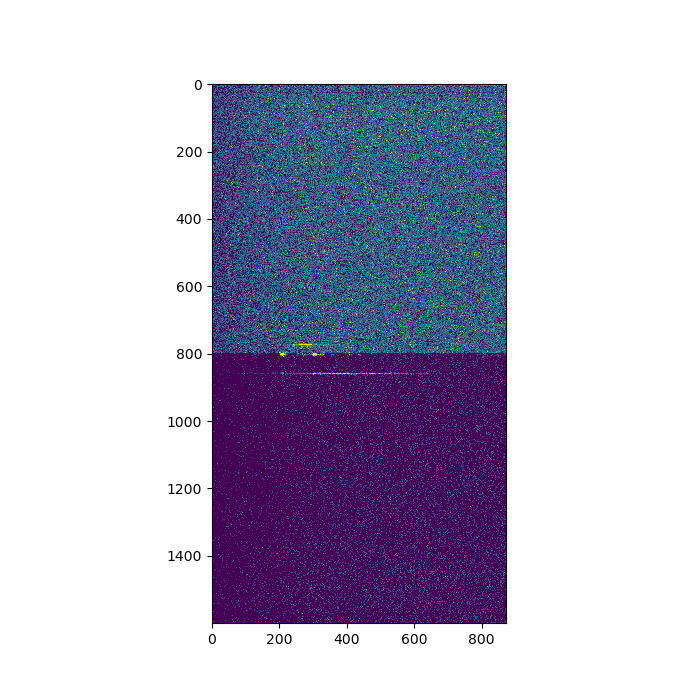

In [30]:
# -- let's look at the signal at the sensor for the first exposure
plt.close("all")
plt.figure(figsize=(7, 7))
plt.imshow(hsi0.data[:, :, 0].T, clim=[50, 75], cmap="viridis")

Text(0.5, 0, 'wavelength [nm]')

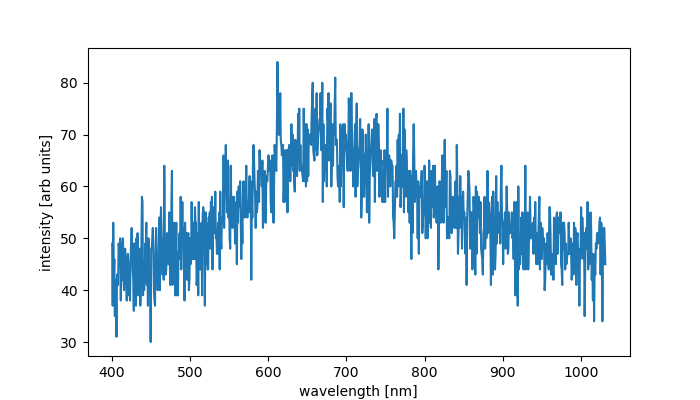

In [31]:
# -- let's look at the spectrum for row 859
plt.close("all")
plt.figure(figsize=(7, 4))
plt.plot(hsi0.waves, hsi0.data[:, 859, 0])
plt.ylabel("intensity [arb units]")
plt.xlabel("wavelength [nm]")

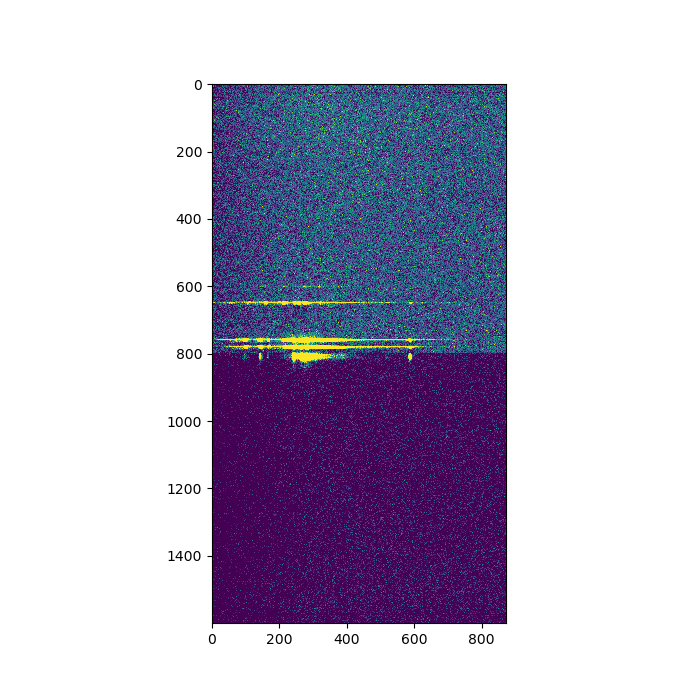

In [32]:
# -- let's look at a column with several bright sources (1294)
plt.close("all")
plt.figure(figsize=(7, 7))
plt.imshow(hsi0.data[:, :, 1294].T, clim=[50, 75], cmap="viridis")

Text(0.5, 0, 'wavelength [nm]')

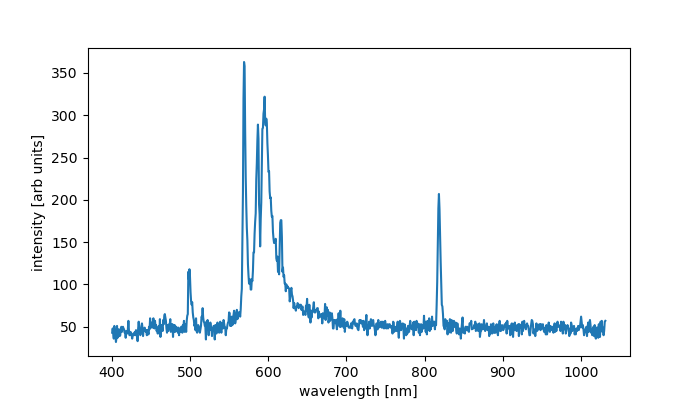

In [33]:
# -- let's look at the spectrum for row 810
plt.close("all")
plt.figure(figsize=(7, 4))
plt.plot(hsi0.waves, hsi0.data[:, 810, 1294])
plt.ylabel("intensity [arb units]")
plt.xlabel("wavelength [nm]")

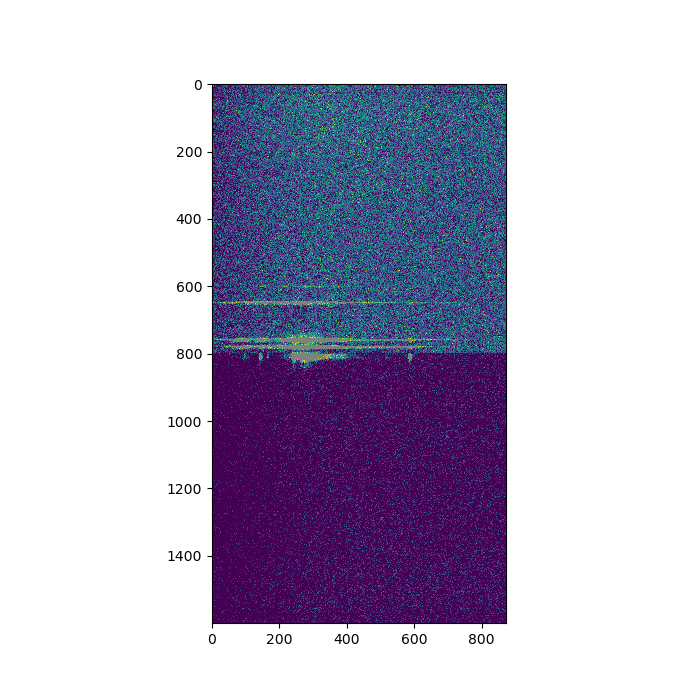

In [34]:
# -- let's try to mask out these bright sources in this exposure
sens = hsi0.data[:, :, 1294]
thr = 75
mask = sens < thr

plt.close("all")
fig, ax = plt.subplots(figsize=(7, 7))
ax.imshow((mask * sens).T, clim=[50, 75], cmap="viridis", alpha=mask.T.astype(float))
ax.set_facecolor("gray")

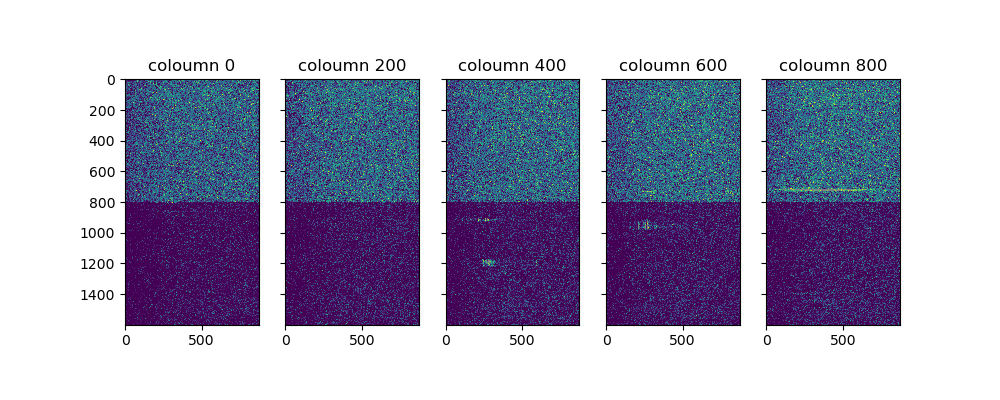

In [35]:
# -- how does this threshold look on other exposures?
plt.close("all")
fig, ax = plt.subplots(1, 5, figsize=(10, 4), sharey=True)

for ii, col in enumerate([0, 200, 400, 600, 800]):
    sens = hsi0.data[:, :, col]
    mask = sens < thr

    ax[ii].imshow((mask * sens).T, clim=[50, 75], cmap="viridis", alpha=mask.T.astype(float))
    ax[ii].set_facecolor("gray")
    ax[ii].set_title("coloumn {0}".format(col))

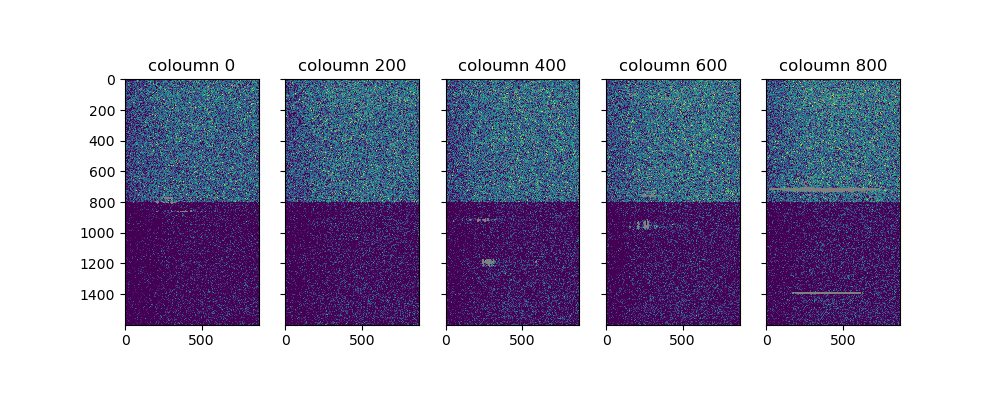

In [36]:
# -- Gaussian filter a bit to remove leakage
wid = 2

plt.close("all")
fig, ax = plt.subplots(1, 5, figsize=(10, 4), sharey=True)

for ii, col in enumerate([0, 200, 400, 600, 800]):
    sens = hsi0.data[:, :, col]
    mask = gf((sens < thr).astype(float), wid) > 0.99

    ax[ii].imshow((mask * sens).T, clim=[50, 75], cmap="viridis", alpha=mask.T.astype(float))
    ax[ii].set_facecolor("gray")
    ax[ii].set_title("coloumn {0}".format(col))

*Looks like things might be different for the top and bottom half, but let's press on*

In [17]:
# -- get the average sensor "background" across all exposures (looping to save memory)
sens_tot = np.zeros(hsi0.data.shape[:2])
cnt = np.zeros(sens_tot.shape, dtype=int)

for ii in range(hsi0.data.shape[2]):
    if (ii + 1) % 100 == 0:
        print("working on column {0} of {1}\r".format(ii + 1, hsi0.data.shape[2]), end="")
    sens = hsi0.data[:, :, ii]
    mask = gf((sens < thr).astype(float), wid) > 0.99
    sens_tot[mask] += sens[mask]
    cnt[mask] += 1

sens_avg = sens_tot / cnt

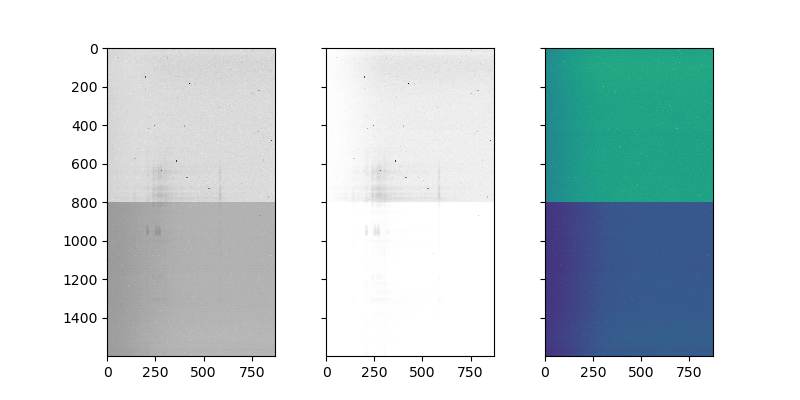

In [37]:
# -- let's look at the totals, counts, and average
plt.close("all")
fig, ax = plt.subplots(1, 3, figsize=(8, 4), sharey=True)
ax[0].imshow(sens_tot.T)
ax[1].imshow(cnt.T)
ax[2].imshow(sens_avg.T, cmap="viridis")

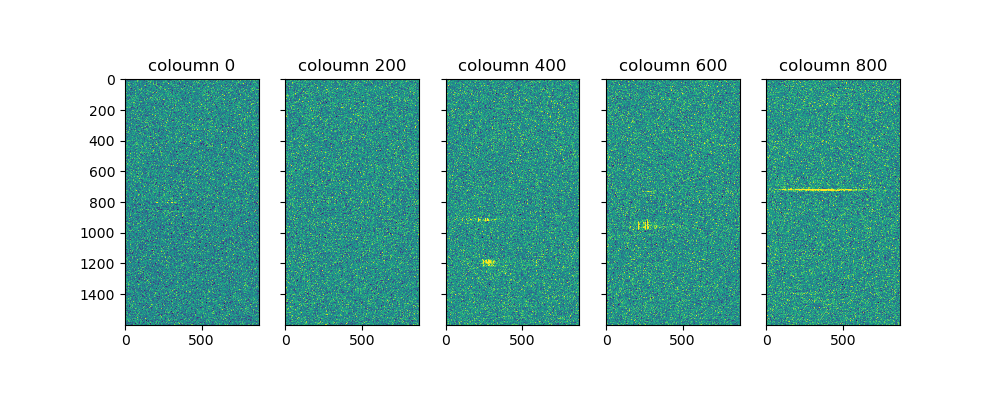

In [38]:
# -- let's remove that background from the columns above
plt.close("all")
fig, ax = plt.subplots(1, 5, figsize=(10, 4), sharey=True)

for ii, col in enumerate([0, 200, 400, 600, 800]):
    clean = hsi0.data[:, :, col] - sens_avg

    ax[ii].imshow(clean.T, clim=[-20, 20], cmap="viridis")
    ax[ii].set_title("coloumn {0}".format(col))

In [20]:
# -- create a "clean" luminosity image (again, loop to save memory)
#    by scaling the mean background for each column to match the top of the exposure
imgLc = np.zeros_like(imgL)

for ii in range(hsi0.data.shape[2]):
    if (ii + 1) % 100 == 0:
        print("working on column {0} of {1}\r".format(ii + 1, hsi0.data.shape[2]), end="")
    sens = hsi0.data[:, :, ii]
    scl = (sens[:, 50:100] / sens_avg[:, 50:100]).mean()
    
    imgLc[:, ii] = (hsi0.data[:, :, ii] - scl * sens_avg).mean(axis=0)

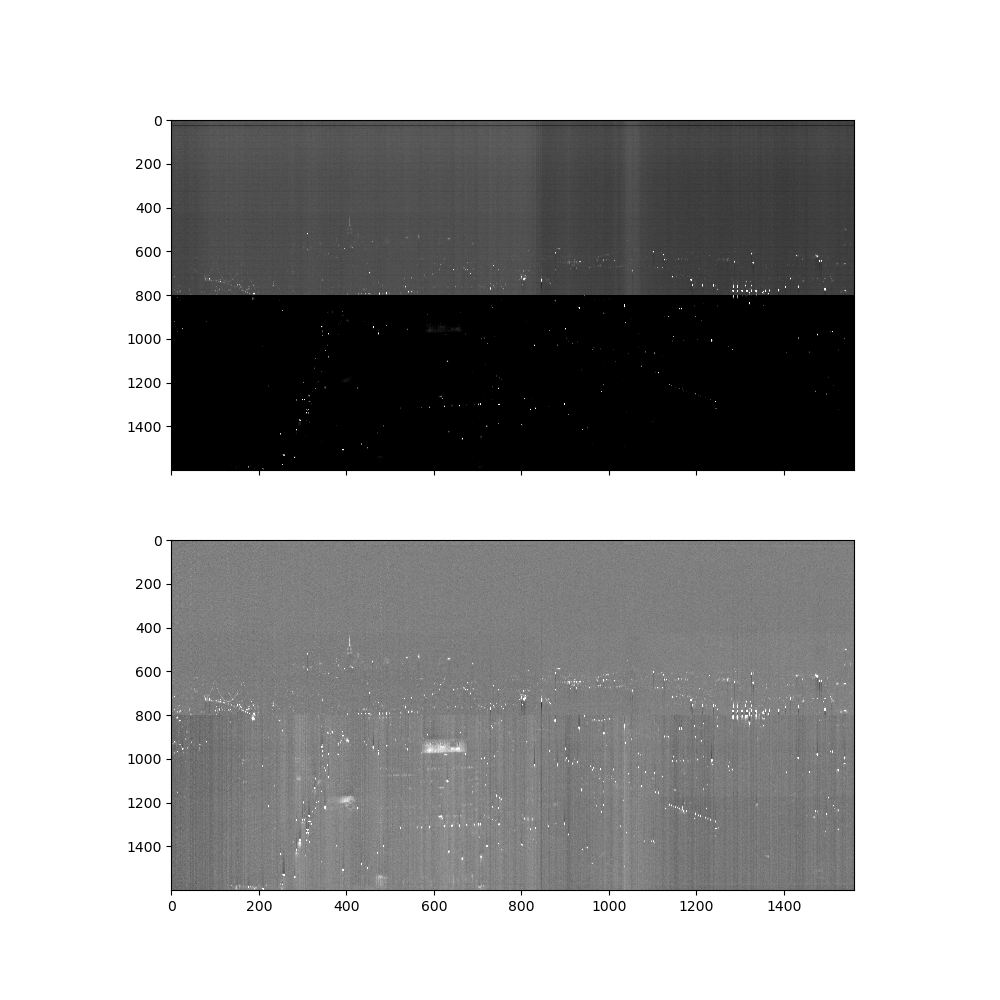

In [39]:
# -- visualize the luminosity images
plt.close("all")
fig, ax = plt.subplots(2, 1, figsize=(10, 10), sharex=True)
ax[0].imshow(imgL, aspect=0.5, clim=[50, 75])
ax[1].imshow(imgLc, aspect=0.5, clim=[-5, 5])

In [22]:
# -- create a "clean" luminosity image (again, loop to save memory)
#    by scaling the mean background for each column to match the top of the exposure
#    and let's treat the bottom and top half separately
imgLc_2 = np.zeros_like(imgL)

for ii in range(hsi0.data.shape[2]):
    if (ii + 1) % 100 == 0:
        print("working on column {0} of {1}\r".format(ii + 1, hsi0.data.shape[2]), end="")
    sens = hsi0.data[:, :, ii]
    scl_top = (sens[:, 50:100] / sens_avg[:, 50:100]).mean()
    scl_bot = (sens[:, -100:-50] / sens_avg[:, -100:-50]).mean()
    
    imgLc_2[:800, ii] = np.median(sens[:, :800] - scl_top * sens_avg[:, :800], axis=0)
    imgLc_2[800:, ii] = np.median(sens[:, 800:] - scl_bot * sens_avg[:, 800:], axis=0)

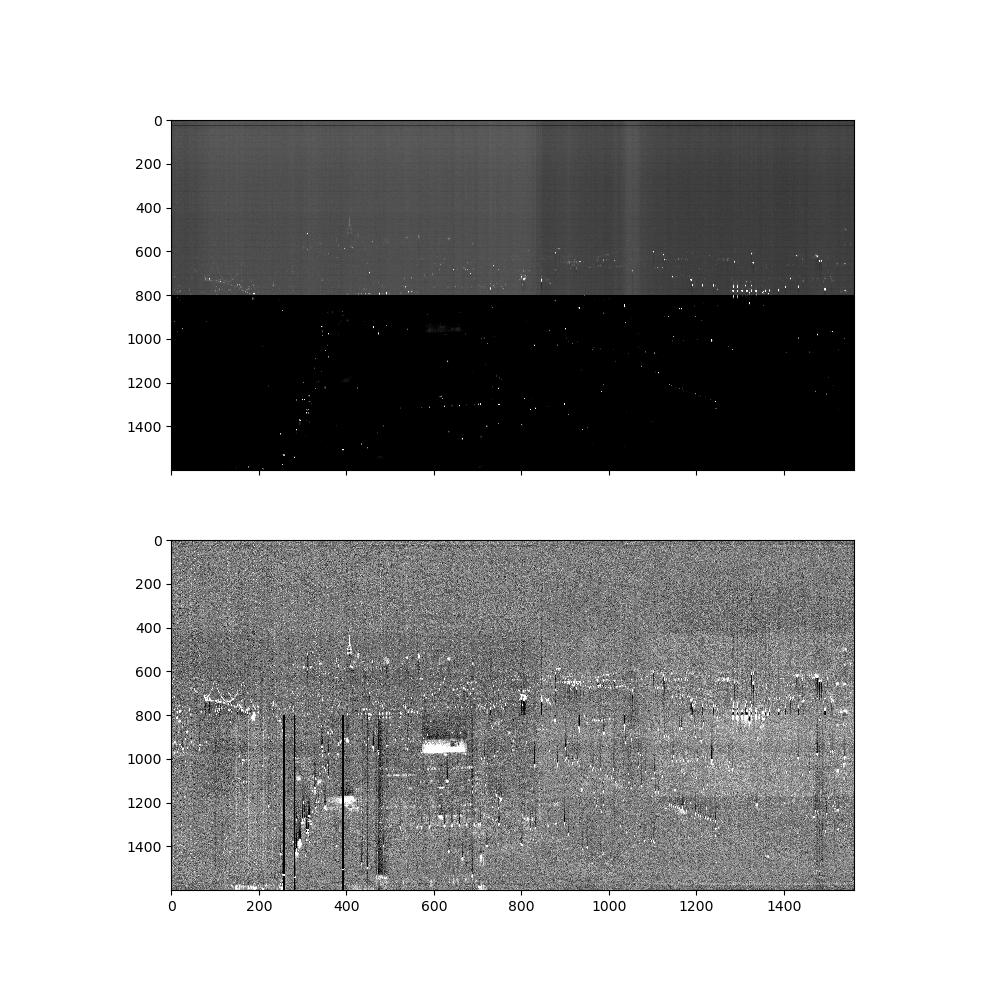

In [40]:
# -- visualize the luminosity images
plt.close("all")
fig, ax = plt.subplots(2, 1, figsize=(10, 10), sharex=True)
ax[0].imshow(imgL, aspect=0.5, clim=[50, 75])
ax[1].imshow(imgLc_2, aspect=0.5, clim=[-1, 1])